# Raster plot 

## 1. Input parameters

In [1]:
# Input parameters

# ------------------------------------------------------------------

# Cells  ID

# ------------------------------------------------------------------


cell_num = 1  # Numbers 1-5
cells_Name = [
    'bNAC219_L1_NGCDA_095997ce92',   # cell 1 L1
    'bNAC219_L1_NGCDA_46b45974f4',   # cell 3 L1
    'cADpyr229_L23_PC_5ecbf9b163'    # cell 1 L23   
]

cell_path_L1 = f'/home/lascon/Documents/241165/AberraEtAl2018/cells/L1_NGC-DA_bNAC219_{cell_num}'
cell_path_L23 = f'/home/lascon/Documents/241165/AberraEtAl2018/cells/L1_NGC-DA_bNAC219_{cell_num}'

cell_Name_L1 = cells_Name[1]
cell_Name_L23 = cells_Name[2]

cell_label_L1 = "_".join(cells_Name[0].split("_")[1:3])
cell_type_L1 = "_".join(cells_Name[0].split("_")[2:3])

cell_label_L23 = "_".join(cells_Name[2].split("_")[1:3])
cell_type_L23 = "_".join(cells_Name[2].split("_")[2:3])


# --------------------------------------------------------------

# Injected current

# --------------------------------------------------------------
# Choose one option a or b

import numpy as np
    # a) Simulate a current for each cell

#current_amps = np.loadtxt('current_amps.dat')    
    
    # b) Use the same current for each cell Ex. -0.015137, 0.0494352, 0.0535548, 0.0576744

current_amps = np.array([-0.015137, 0.0494352, 0.0535548, 0.0576744])  




## 2. Raster plot from json file

In [2]:


import json
with open(f"{cell_path_L1}/step_01_data.json") as f:
    data = json.load(f)

print(data.keys())
print(data["simData"].keys())


dict_keys(['net', 'netpyne_changeset', 'netpyne_version', 'simConfig', 'simData'])
dict_keys(['LFP', 'V_axon_0', 'V_axon_1', 'V_dend_0', 'V_dend_1', 'V_dend_2', 'V_dend_3', 'V_soma', 'avgRate', 'spkid', 'spkt', 'stims', 't'])


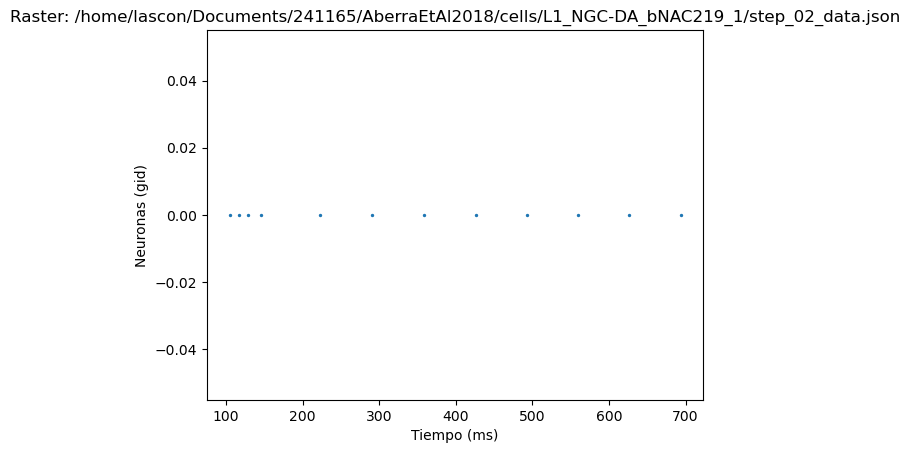

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

def raster_from_netpyne_json(json_file, timeRange=None, marker_size=2):
    with open(json_file) as f:
        data = json.load(f)

    simData = data.get("simData", {})

    spkt = np.array(simData.get("spkt", []), dtype=float)   # spike times (ms)
    spkid = np.array(simData.get("spkid", []), dtype=int)   # cell gids

    if spkt.size == 0 or spkid.size == 0:
        raise RuntimeError(
            "El JSON no contiene spkt/spkid (o están vacíos). "
            "Revisa si tu archivo guarda spikes en simData."
        )

    if timeRange is not None:
        t0, t1 = timeRange
        m = (spkt >= t0) & (spkt <= t1)
        spkt = spkt[m]
        spkid = spkid[m]

    plt.figure()
    plt.scatter(spkt, spkid, s=marker_size)
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Neuronas (gid)")
    plt.title(f"Raster: {json_file}")
    plt.show()

# uso
raster_from_netpyne_json(f"{cell_path_L1}/step_02_data.json", timeRange=(0, 800))


## 3. Raster plot cell population 

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

def raster_10cells_from_json(json_file, timeRange=(0, 800), gids=None, marker_size=2):
    with open(json_file) as f:
        data = json.load(f)

    simData = data.get("simData", {})
    spkt = np.array(simData.get("spkt", []), dtype=float)
    spkid = np.array(simData.get("spkid", []), dtype=int)

    if spkt.size == 0 or spkid.size == 0:
        raise RuntimeError("El JSON no tiene spkt/spkid (o están vacíos). No se puede hacer raster poblacional.")

    # filtra por rango de tiempo
    t0, t1 = timeRange
    m = (spkt >= t0) & (spkt <= t1)
    spkt, spkid = spkt[m], spkid[m]

    # escoger 10 neuronas
    unique_gids = np.unique(spkid)
    if gids is None:
        gids = unique_gids[:10]              # primeras 10 que aparecen
    else:
        gids = np.array(gids, dtype=int)

    m2 = np.isin(spkid, gids)
    spkt10, spkid10 = spkt[m2], spkid[m2]

    # mapear gids a filas 0..9 para que quede “bonito”
    gid_to_row = {gid: i for i, gid in enumerate(gids)}
    y = np.array([gid_to_row[g] for g in spkid10], dtype=int)

    plt.figure()
    plt.scatter(spkt10, y, s=marker_size)
    plt.yticks(range(len(gids)), [str(g) for g in gids])
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Neuronas (gid)")
    plt.title(f"Raster (10 neuronas) - {json_file}")
    plt.show()

    return gids

# Uso:
gids_usados = raster_10cells_from_json(
    f"{cell_path_L1}/step_01_data.json",
    timeRange=(0, 800)
)
print("GIDs usados:", gids_usados)


In [ ]:
raster_10cells_from_json(f"{cell_path_L1}/step_02_data.json", gids=[0,1,2,3,4,5,6,7,8,9])
